#  Анализ и подготовка плана действий по удержанию клиентов в сети фитнес-центров

## Введение

**Данное исследование направлено на** разработку стратегии по удержанию клиентов сети фитнес-центров «Культурист-датасаентист» на основе аналитических данных. **Потребность в исследовании** обусловлена наиболее распространённой проблемой фитнес-клубов и других сервисов — оттоком клиентов. 

Как правило, клиенты чаще перестают пользоваться сервисом тихо. Индикаторы оттока зависят от специфики отрасли. Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал. 

**Исследование построено** на анкетах пользователей «Культуриста-датасаентиста».

**Иследование состоит** из следующих этапов:

1. [Обзор данных и их предобработка](#step_1):
    * [Импорт библиотек](#step_1.1);
    * [Общая информация о данных](#step_1.2);
    * [Типы данных, обработка пропусков и дубликатов](#step_1.3);
    * [Вывод](#step_1.4).
2. [Исследовательский анализ данных](#step_2):
    * [Изучение и проверка данных](#step_2.1);
    * [Анализ средних значений показателей](#step_2.2);
    * [Анализ распределений признаков](#step_2.3);
    * [Матрица корреляций](#step_2.4);
    * [Вывод](#step_2.5).
3. [Построение модели прогнозирования оттока пользователей](#step_3):
    * [Выделение обучающей и валидационной выборок](#step_3.1);
    * [Обучение модели](#step_3.2);
    * [Оценка метрик и сравнение моделей](#step_3.3);
    * [Вывод](#step_3.4)
4. [Кластеризация пользователей](#step_4);
    * [Стандартизация данных](#step_4.1);
    * [Построение матрицы расстояний и дендрограммы](#step_4.2);
    * [Обучение модели кластеризации и прогноз кластеров клиентов](#step_4.3);
    * [Анализ распределения признаков для кластеров](#step_4.4);
    * [Расчёт и анализ долей оттока для кластеров](#step_4.5);
    * [Вывод](#step_4.6).
5. [Общий вывод](#step_5);
6. [Рекомендации](#step_6);

**Результатами исследования** являются рекомендации для стратегии взаимодействия с пользователями сети фитнес-центров «Культурист-датасаентист» и их удержания.

## Этап 1. Обзор данных и их предобработка <a id='step_1'></a>

### Импорт библиотек <a id='step_1.1'></a>

In [1]:
import pandas as pd
import numpy as np
from IPython import display

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans

from scipy.cluster.hierarchy import dendrogram, linkage

import matplotlib.pyplot as plt
import seaborn as sns

### Общая информация о данных <a id='step_1.2'></a>

In [2]:
# Прочитаем файл gym_churn.csv с информацией о логах в приложении и сохраним его в переменной gym_churn
gym_churn = pd.read_csv('C:/Users/Public/Jupyter/gym_churn.csv')
gym_churn.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [3]:
display.display(data=gym_churn.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

Данные представлены в виде таблицы, включающей в себя 4 000 строк и 14 столбцов, тип данных у десяти столбцов - целочисленный (< int >), у четырёх остальных - < float >. Разберём, какие в таблице столбцы, и какую информацию они содержат. Данные можно разделить на категории:

1. Данные пользователя за предыдущий до проверки факта оттока месяц:
    - [`gender`](#gender) — пол;
    - [`Near_Location`](#near_loc) — проживание или работа в районе, где находится фитнес-центр;
    - [`Partner`](#partner) — сотрудник компании-партнёра клуба (такие сотрудники могут получать скидки на абонемент);
    - [`Promo_friends`](#promo) — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
    - [`Phone`](#phone) — наличие контактного телефона;
    - [`Age`](#age) — возраст;
    - [`Lifetime`](#lifetime) — время с момента первого обращения в фитнес-центр (в месяцах).
2. Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
    - [`Contract_period`](#contract_per) — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
    - [`Month_to_end_contract`](#to_end) — срок до окончания текущего действующего абонемента (в месяцах);
    - [`Group_visits`](#group) — факт посещения групповых занятий;
    - [`Avg_class_frequency_total`](#avg_freq_total) — средняя частота посещений в неделю за все время с начала действия абонемента;
    - [`Avg_class_frequency_current_month`](#avg_freq_month) — средняя частота посещений в неделю за месяц;
    - [`Avg_additional_charges_total`](#avg_ad_charge) — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон;
3. Ключевое поле:
    - [`Churn`](#churn) — факт оттока в текущем месяце.

Отметим, что количество строк в каждом столбце одинаково, что говорит нам о том, что в таблице, скорее всего, нет пропущенных данных. Практически все столбцы имеют соответствующий своему значению тип данных. Однако, столбец `Month_to_end_contract` - это столбец с информацией о количестве месяцев, который принимает целые значения, поэтому необходимо его преобразование. Округления данных с плавающей точкой мы производить не будем, поскольку в анализе моджет быть важно различие отдельных пользователей по показателям, а с округлением мы можем это потерять. Большинство столбцов являются бинарными: принимают значения 0 или 1. Также для удобства анализа следует привести названия столбцов к нижнему регистру. 

### Типы данных, обработка пропусков и дубликатов <a id='step_1.3'></a>

#### Замена названий столбцов

При анализе информации об исходных датасетах мы обратили внимание на то, что для дальнейшего анализа необходимо привести названия столбцов таблицы `gym_churn` к одному (нижнему) регистру.

In [4]:
gym_churn.columns = gym_churn.columns.str.lower()
gym_churn.columns

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')

Все названия столбцов имеют подходящий для анализа вид.

#### Типы данных

Выше мы указали столбец, который требует изменения типа данных: это данные с информацией о сроке до окончания текущего действующего абонемента `month_to_end_contract`.

In [5]:
gym_churn['month_to_end_contract'] = gym_churn['month_to_end_contract'].astype('int')

In [6]:
# Проверим, что тип данных заменён везде, где это требовалось
display.display(data=gym_churn.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   int32  
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

#### Обработка пропусков

Проверим отсутствие пропусков в данных.

In [7]:
gym_churn.isna().sum()

gender                               0
near_location                        0
partner                              0
promo_friends                        0
phone                                0
contract_period                      0
group_visits                         0
age                                  0
avg_additional_charges_total         0
month_to_end_contract                0
lifetime                             0
avg_class_frequency_total            0
avg_class_frequency_current_month    0
churn                                0
dtype: int64

#### Обработка дубликатов

Проверим отсутствие дубликатов в данных.

In [8]:
gym_churn.duplicated().sum()

0

### Вывод <a id='step_1.4'></a>

У нас имеется исходная информация о данных пользователя за предыдущий до проверки факта оттока месяц, информация на основе журнала посещений, покупок, а также информация о текущем статусе абонемента клиента. 

Данные представлены в виде таблицы, включающей в себя 4 000 строк и 14 столбцов с полом, фактом проживания или работы в районе фитнес-центра, выделением сотрудников компании-партнёра клуба, фактом первоначальной записи в рамках акции «приведи друга», обозначением наличия контактного телефона, возрастом, временем с момента первого обращения в фитнес-центр, длительностью текущего действующего абонемента, сроком до окончания текущего действующего абонемента, фактом посещения групповых занятий, средняя частотой посещений в неделю за все время с начала действия абонемента и за предыдущий месяц, суммарной выручкой от других услуг фитнес-центра, фактом оттока в текущем месяце. 

На этапе подготовки данных названия столбцов в таблице были приведены к нижнему регистру, был изменен тип данных столбца с информацией о сроке до окончания текущего действующего абонемента. Пропусков и дубликатов в данных не было обнаружено.

## Этап 2. Исследовательский анализ данных (EDA) <a id='step_2'></a>

### Изучение и проверка данных <a id='step_2.1'></a>

In [9]:
gym_churn.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


Изучим данные по каждому столбцу.

#### Пол <a id='gender'></a>

In [10]:
gym_churn['gender'].describe()

count    4000.000000
mean        0.510250
std         0.499957
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: gender, dtype: float64

In [11]:
gym_churn['gender'].unique()

array([1, 0], dtype=int64)

У нас имеются данные о мужчинах и женщинах, которые обозначаются 0 и 1. При этом в выборке их равное количество (так как выборка имеет чётное число данных, средняя близка к 0,5, а медианное значение равно 1).

#### Близость к району с фитнес-центром <a id='near_loc'></a>

In [12]:
gym_churn['near_location'].describe()

count    4000.000000
mean        0.845250
std         0.361711
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: near_location, dtype: float64

In [13]:
gym_churn['near_location'].unique()

array([1, 0], dtype=int64)

У нас имеются данные о людях, которые живут или работают рядом с фитнес-центром, либо в отдалённости от него. Категории обозначаются 0 и 1. При этом в выборке больше тех, кто живёт или работает рядом (так как средняя близка к 0,85, а первый квартиль равен 1).

#### Сотрудник компании-партнёра клуба <a id='partner'></a>

In [14]:
gym_churn['partner'].describe()

count    4000.000000
mean        0.486750
std         0.499887
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: partner, dtype: float64

In [15]:
gym_churn['partner'].unique()

array([1, 0], dtype=int64)

Данные о людях, которые являются или не являются сотрудниками компании-партнёра клуба, обозначаются 0 и 1. При этом в выборке примерно в равной пропорции представлены обе группы (средняя близка к 0,5).

#### Первый абонемент по акции "Приведи друга" <a id='promo'></a>

In [16]:
gym_churn['promo_friends'].describe()

count    4000.000000
mean        0.308500
std         0.461932
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: promo_friends, dtype: float64

In [17]:
gym_churn['promo_friends'].unique()

array([1, 0], dtype=int64)

У нас имеются данные о людях, которые приобрели или не приобрели первый абонемент по акции "Приведи друга". Категории обозначаются 0 и 1. При этом в выборке больше тех, кто не пришёл по данной акции (так как средняя близка к 0,3, а медиана равна 0).

#### Наличие контактного телефона <a id='phone'></a>

In [18]:
gym_churn['phone'].describe()

count    4000.000000
mean        0.903500
std         0.295313
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: phone, dtype: float64

In [19]:
gym_churn['phone'].unique()

array([0, 1], dtype=int64)

В имеющихся данных по клиентам либо есть данные о контактном телефоне (значение 1), либо их нет (значение 0). При этом в выборке больше тех, для кго представлена контактная информация (так как средняя близка к 0,9, а четвёртый квартиль равен 1).

#### Возраст <a id='phone'></a>

In [20]:
gym_churn['age'].describe()

count    4000.000000
mean       29.184250
std         3.258367
min        18.000000
25%        27.000000
50%        29.000000
75%        31.000000
max        41.000000
Name: age, dtype: float64

In [21]:
gym_churn['age'].sort_values().unique()

array([18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 41], dtype=int64)

У нас имеются данные о клиентах возрастом от 18 до 41 года (при этом нет клиентов в возрасте 40 лет). Средний возраст равен 29 годам. При этом люди разного возраста выбраны достаточно равномерно (так как средняя близка к медиане, а стандартное отклонение очень низкое).

#### Время с момента первого обращения <a id='lifetime'></a>

In [22]:
gym_churn['lifetime'].describe()

count    4000.000000
mean        3.724750
std         3.749267
min         0.000000
25%         1.000000
50%         3.000000
75%         5.000000
max        31.000000
Name: lifetime, dtype: float64

In [23]:
gym_churn['lifetime'].sort_values().unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 29, 31], dtype=int64)

У нас имеются данные о клиентах, которые обращались в фитнес-центр впервые от 0 до 31 месяца назад (при этом нет клиентов, у которых прошло 25, 28 или 30 месяцев с момента первого обращения). Среднее время с момента первого обращения составляет 3 месяца. При этом есть небольшой перекос в данных, так как среднее значение ближе к 4 месяцам.

#### Длительность действующего абонемента <a id='contract_per'></a>

In [24]:
gym_churn['contract_period'].describe()

count    4000.000000
mean        4.681250
std         4.549706
min         1.000000
25%         1.000000
50%         1.000000
75%         6.000000
max        12.000000
Name: contract_period, dtype: float64

In [25]:
gym_churn['contract_period'].sort_values().unique()

array([ 1,  6, 12], dtype=int64)

Действующий абонемент по рассматриваемым клиентам имеет срок в 1, 6 и 12 месяцев (в выборку не попали клиенты, у которых срок составляет 3 месяца). Средняя длительность действующего абонемента составляет 4-5 месяцев. При этом есть перекос в данных: для большинства срок действующего абонемента равен 1 месяцу.

#### Срок до окончания действующего абонемента <a id='to_end'></a>

In [26]:
gym_churn['month_to_end_contract'].describe()

count    4000.000000
mean        4.322750
std         4.191297
min         1.000000
25%         1.000000
50%         1.000000
75%         6.000000
max        12.000000
Name: month_to_end_contract, dtype: float64

In [27]:
gym_churn['month_to_end_contract'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

У нас имеются данные по клиентам, до окончания абонементов которых осталось от 1 до 12 месяцев. В среднем это значение около 4 месяцев. При этом больше половины всей выборки - это люди, до конца абонементов которых остался 1 месяц.

#### Посещение групповых занятий <a id='group'></a>

In [28]:
gym_churn['group_visits'].describe()

count    4000.000000
mean        0.412250
std         0.492301
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: group_visits, dtype: float64

In [29]:
gym_churn['group_visits'].unique()

array([1, 0], dtype=int64)

У нас есть данные о клиентах, которые посещают групповые занятия (значение 1) или не посещают (значение 0). При этом в выборке чуть больше тех, кто не посещает такие занятия (средняя близка к 0,4, а медиана равна 0).

#### Средняя частота посещений в неделю за все время <a id='avg_freq_total'></a>

In [30]:
gym_churn['avg_class_frequency_total'].describe()

count    4000.000000
mean        1.879020
std         0.972245
min         0.000000
25%         1.180875
50%         1.832768
75%         2.536078
max         6.023668
Name: avg_class_frequency_total, dtype: float64

У нас имеются данные по клиентам со средней частотой посещений за все время с начала действия абонемента от 0 до 6 раз в неделю. В среднем это значение составляет около 2 раз в неделю. При этом выборка равномерная, так как среднее почти равно медиане, а стандартное отклонение невысоко.

#### Средняя частота посещений в неделю за предыдущий месяц <a id='avg_freq_month'></a>

In [31]:
gym_churn['avg_class_frequency_current_month'].describe()

count    4000.000000
mean        1.767052
std         1.052906
min         0.000000
25%         0.963003
50%         1.719574
75%         2.510336
max         6.146783
Name: avg_class_frequency_current_month, dtype: float64

У нас имеются данные по клиентам со средней частотой посещений за месяц от 0 до 6 раз в неделю. В среднем это значение составляет около 2 раз в неделю. При этом выборка равномерная, так как среднее почти равно медиане, а стандартное отклонение невысоко.

#### Выручка от других услуг фитнес-центра <a id='avg_ad_charge'></a>

In [32]:
gym_churn['avg_additional_charges_total'].describe()

count    4000.000000
mean      146.943728
std        96.355602
min         0.148205
25%        68.868830
50%       136.220159
75%       210.949625
max       552.590740
Name: avg_additional_charges_total, dtype: float64

Выручка от прочих услуг фитнес-центра составила от 0,15 до 552,6 ден.ед. В среднем это значение составляет около 147 ден.ед., медиана равна 136 ден.ед. Разброс данных очень большой (мы не знаем наверняка, в каких ден.ед. измеряются данные).

#### Отток в текущем месяце <a id='churn'></a>

In [33]:
gym_churn['churn'].describe()

count    4000.000000
mean        0.265250
std         0.441521
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: churn, dtype: float64

У нас есть данные о клиентах, которые продолжают пользоваться услугами фитнес-центра (значение 0) и тех, кто "ушёл" (значение 1). При этом в выборке больше тех, кто продолжает пользоваться услугами (средняя близка к 0,3, а медиана равна 0).

### Анализ средних значений показателей <a id='step_2.2'></a>

Изучим средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался. 

In [34]:
gym_churn.groupby('churn').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


Если среднее значение по бинарным показателям (0 и 1) ближе к 1, значит, людей с признаком больше, чем без него; если меньше 0,5, значит, их меньше.

*По полу* у нас имеется примерно равное количество человек разного пола в двух группах.

*По близости* к фитнес-центру в группе, которая лояльна к фитнес-центру чуть больше человек, которые живут или работают поблизости, чем тех, кто находится в отдалённости.

Есть различия в оттоке между теми, кто *является сотрудником компании-партнёра* клуба. Среди тех, кто остался примерно половина и тех, кто связан с партнёрами, и тех, кто не связан, с небольшим преобладанием первых. Но из тех, кто ушёл в отток, больше клиентов, не связанных с компанией-партнёром.

В обеих группах больше людей, которые приобрели первый абонемент не *по промо-акции "Приведи друга"*. Но среди тех, кто остался, пришедших по промо-акции больше.

Нет различий между группами в *наличии контактного телефона* клиентов - практически все оставляют контакты для связи.

*Длительность действующего абонемента* по оставшимся пользователям в среднем около 5-6 месяцев, а по ушедшим - 1-2 месяца. Это говорит о том, что купившие длительный абонемент с большей неохотой уйдут в отток, чем те, у кого он действует на короткий срок.

*Посещение групповых занятий* по выделенным группам также отличается: среди оставшихся клиентов распределение посещающих такие занятия и непосещающих примерно равномерно (вторых чуть больше); но среди тех, кто ушёл в отток, непосещающих групповые занятия значительно больше, чем тех, кто их посещает.

В группе лояльных фитнес-центру людей *средний возраст* составляет около 30 лет, а среди уходящих - около 27 лет. То есть вторая группа чуть младше.

*Средняя выручка от других услуг фитнес-центра* между группами разнится на 43 ден.ед. (в группе лояльных она выше, чем в группе уходящих).

В среднем *срок до окончания* действующего абонемента у людей, ушедших в отток около 1-2 месяцев, а у оставшихся клиентов - около 5 месяцев. Это снова указывает на то, что уходят в большей степени те, у кого длительность оставшегося абонемента невысока.

*Время с момента первого обращения* для уходящих в отток равно 1 месяцу, а для тех, кто остался, близко к 5 месяцам. Таким образом, лояльные первые месяцы клиенты, скорее всего, не уйдут в отток после длительного периода пользования услугами фитнес-центра.

*Средняя частота посещений в неделю за время действия абонемента* в группах не сильно отличается. Лояльные клиенты в среднем посещают центр 2 раза в неделю, а ушедшие - от 1 до 2.

Разница между группами в *средней частоте посещений в неделю за месяц* также не сильно высока: не ушедшие в отток клиенты в среднем посещали фитнес-клуб 2 раза в неделю, а ушедшие в отток - 1 раз в неделю.

### Анализ распределений признаков <a id='step_2.3'></a>

In [35]:
# Разделим выборки на клиентов, ушедших в отток (churn_clients), и клиентов, которые остались (loyal_clients)
churn_clients = gym_churn.query('churn == 1')
loyal_clients = gym_churn.query('churn == 0')

Построим столбчатые гистограммы и распределения признаков для обоих групп

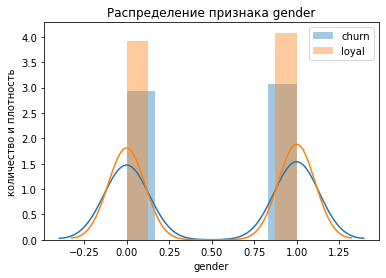

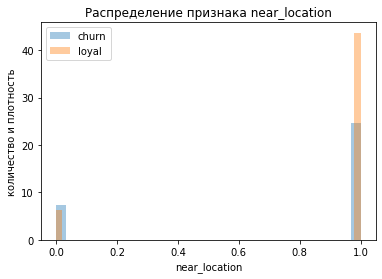

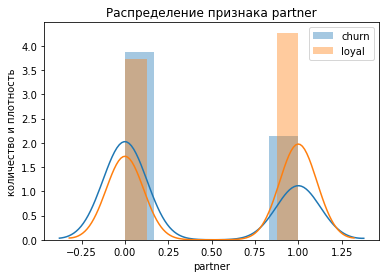

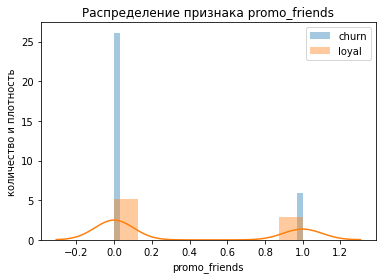

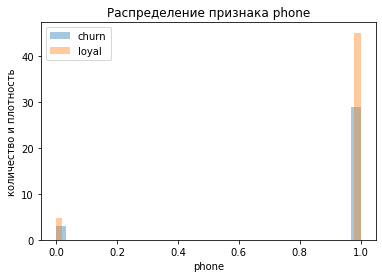

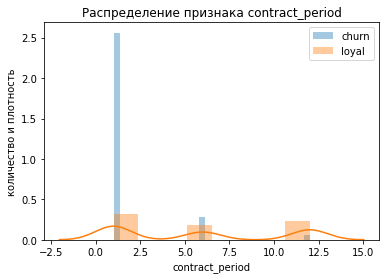

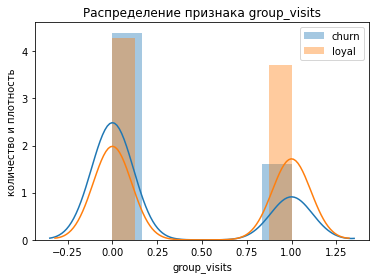

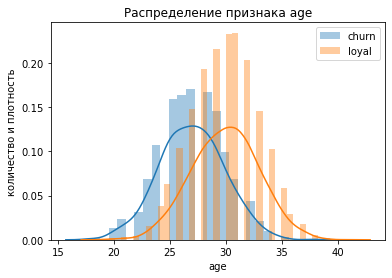

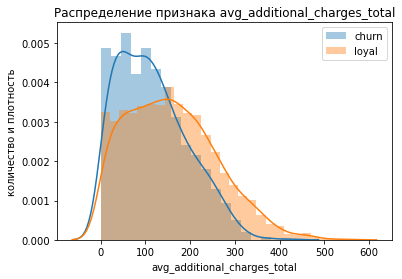

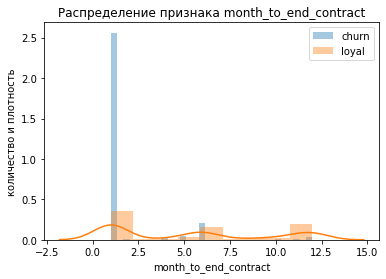

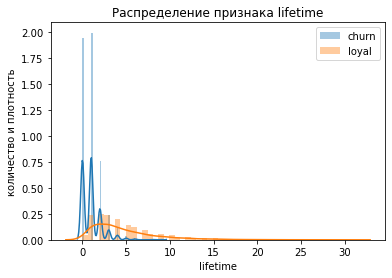

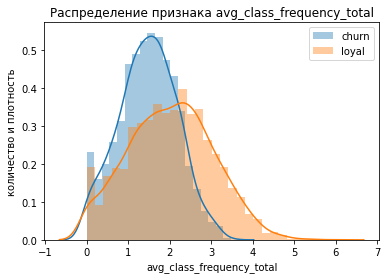

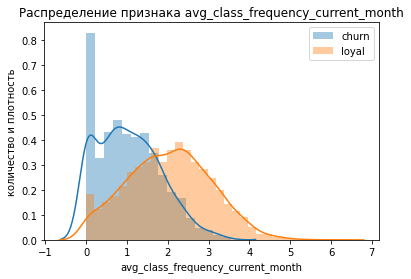

In [36]:
fig, ax = plt.subplots()
for column in gym_churn.drop('churn', axis = 1).columns:
    plt.title("Распределение признака "+column)
    plt.xlabel(column)
    plt.ylabel("количество и плотность")
    sns.distplot(churn_clients[column], label='churn')
    sns.distplot(loyal_clients[column], label='loyal')
    plt.legend()
    plt.show()

*По полу*, *близости к фитнес-центру*, *наличию контактного телефона* обе группы имеют схожее равномерное распределение.

Есть различия в распределении групп между теми, кто *является сотрудником компании-партнёра* клуба и не является. В группе лояльных клиентов число имеющих отношение к компании-партнёра сотрудников явно больше, чем среди тех, кто уходит в отток. Различия в распределении групп по *посещению групповых занятий* такие же, как и в распределениях по принадлежности к компании-партнёру.

Среди тех, кто остался, *по промо-акции "Приведи друга"* клиентов немного больше, но распределения схожи.

Распределение *длительности действующего абонемента* по оставшимся пользователям и ушедшим различается. Лояльных клиентов, приобретающих абонемент на 1 месяц больше всего, меньше их сроком на год, и наименьшее количество клиентов - на 6 месяцев. А для ушедших в отток 1 месяц - самый популярный, затем - 6 месяцев (с очень низким числом абонементов), и практически нет абонементов на 12 месяцев. Различия в распределении групп по *сроку до окончания действующего абонемента* такие же, как и в распределениях по длительности абонемента.

По *среднему возрасту* обе группы имеют нормальное распределение, но датасет лояльных клиентов немного смещён вправо, а датасет ушедших клиентов - влево.

Распределение *средней выручки от других услуг фитнес-центра* для обоих датасетов смещено влево с большим смещением для ушедших людей. То есть те, кто уходит, практически ничего не тратят на дополнительные услуги в фитнес-центре.

Распределение *времени с момента первого обращения* для обоих групп похоже на распределение Пуассона. Но для ушедших в отток клиентов оно сильно смещено влево, практически не имея значения в более высоких значениях, а для лояльных клиентов принимает более высокие значения.

Распределение для *средней частоты посещений в неделю за время действия абонемента* в обоих группах является нормальным. Для лояльной группы оно немного смещено влево, а для группы уходящих в отток имеется сильное смещение влево. Аналогичные различия между группами наблюдаются и для распределений *средней частоты посещений в неделю за месяц*.

### Матрица корелляций <a id='step_2.4'></a>

Построим матрицу корреляций для всех показателей и отобразим её.

In [37]:
correlation = gym_churn.corr()
correlation

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
gender,1.000000,0.006699,-0.010463,-0.005033,-0.008542,0.000502,0.017879,0.013807,-0.009334,-0.001281,0.013579,0.014620,0.009156,0.000708
near_location,0.006699,1.000000,-0.005119,0.210964,-0.015763,0.150233,0.154728,0.058358,0.040761,0.143961,0.070921,0.043127,0.062664,-0.128098
partner,-0.010463,-0.005119,1.000000,0.451960,0.009970,0.306166,0.022710,0.047480,0.022941,0.294632,0.061229,0.024938,0.045561,-0.157986
promo_friends,-0.005033,0.210964,0.451960,1.000000,0.001982,0.244552,0.120170,0.050113,0.036898,0.239553,0.072721,0.028063,0.053768,-0.162233
phone,-0.008542,-0.015763,0.009970,0.001982,1.000000,-0.006893,-0.010099,-0.011403,0.009279,-0.011196,-0.018801,0.008340,0.013375,-0.001177
contract_period,0.000502,0.150233,0.306166,0.244552,-0.006893,1.000000,0.169991,0.138249,0.111445,0.973064,0.170725,0.096211,0.159407,-0.389984
group_visits,0.017879,0.154728,0.022710,0.120170,-0.010099,0.169991,1.000000,0.080934,0.032079,0.163703,0.075853,0.056695,0.075923,-0.175325
age,0.013807,0.058358,0.047480,0.050113,-0.011403,0.138249,0.080934,1.000000,0.080240,0.134511,0.164693,0.119953,0.183095,-0.404735
avg_additional_charges_total,-0.009334,0.040761,0.022941,0.036898,0.009279,0.111445,0.032079,0.080240,1.000000,0.113958,0.079028,0.044426,0.079570,-0.198697
month_to_end_contract,-0.001281,0.143961,0.294632,0.239553,-0.011196,0.973064,0.163703,0.134511,0.113958,1.000000,0.161078,0.085387,0.147605,-0.381393


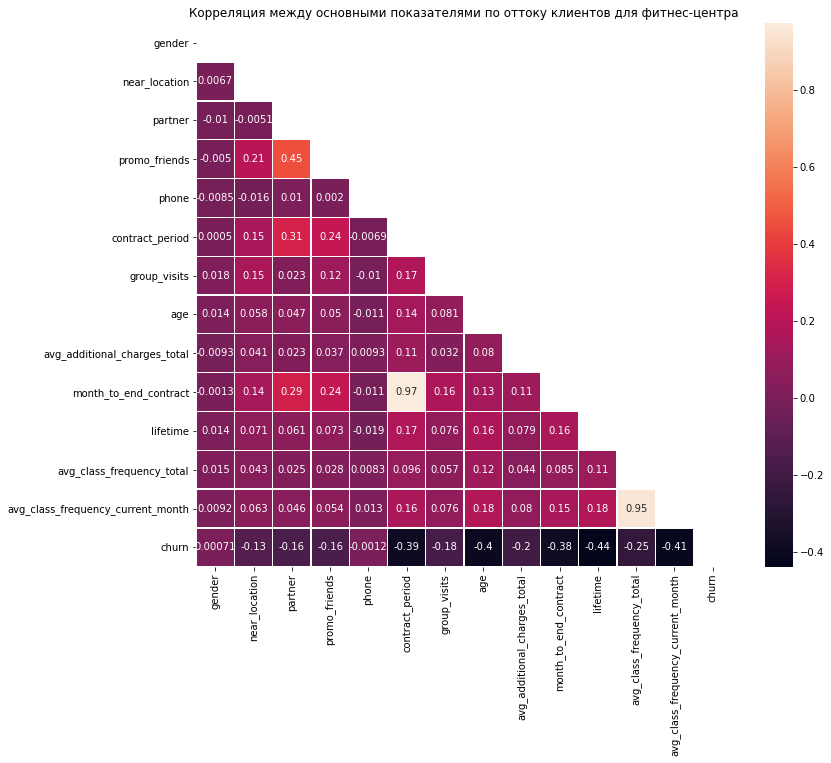

In [38]:
fig, ax = plt.subplots(figsize=(12,10))
plt.title("Корреляция между основными показателями по оттоку клиентов для фитнес-центра")
mask = np.triu(np.ones_like(correlation, dtype=np.bool))
sns.heatmap(correlation, linewidths=.3, annot=True, mask=mask, ax=ax)
ax.set_ylim(14, 0);

На основе корреляции мы видим, что такие признаки как пол и наличие контактного телефона почти не влияют на конечный показатель оттока. Все остальные показатели имеют обратное влияние: слабое, либо чуть более сильное. Явно влияющих признаков, сильно связанных с результирующим показателем, предварительный анализ не выделил.

Также отметим, что имеется сильная связь между показателями длительности абонемента и количеством месяцев до конца абонемента. Это говорит о том, что в выборке представлены клиенты, которые отобраны на определённом этапе покупки абонемента. Скорее всего, в начале действия абонемента. Также наблюдается сильная связь между средней частотой посщений в неделю с начала пользования услугами и за предыдущий месяц. Это говорит о другой зависимости: скорее всего, клиенты посещают фитнес-центр примерно одинаковое число раз в неделю вне зависимости от того, сколько они пользуются услугами центра. 

Для того, чтобы такие признаки не доминировали над остальными переменными при обучении, удалим из модели `month_to_end_contract` и `avg_class_frequency_total`.

In [39]:
gym_churn = gym_churn.drop(['month_to_end_contract', 'avg_class_frequency_total'], axis=1)

### Вывод <a id='step_2.5'></a>

Исследовательский анализ данных (*EDA*) позволил сделать **следующие выводы**.

**Анализ показателей**:

*Отток клиентов*. У нас есть данные о клиентах, которые продолжают пользоваться услугами фитнес-центра (лояльные клиенты) и тех, кто "ушёл" (нелояльные клиенты). При этом в выборке больше тех, кто продолжает пользоваться услугами (средняя близка к 0,3, а медиана равна 0).

*Пол клиентов*. У нас имеются данные о мужчинах и женщинах. При этом в выборке их равное количество (средняя близка к 0,5, а медианное значение равно 1). Для уходящих в отток клиентов и остающихся распределения этого признака имеют схожий вид.

*Близость к фитнес-центру*. У нас имеются данные о людях, которые живут или работают рядом с фитнес-центром, либо в отдалённости от него. При этом в выборке больше тех, кто живёт или работает рядом (так как средняя близка к 0,85, а первый квартиль равен 1). А в группе, которая лояльна к фитнес-центру, чуть больше человек, которые живут или работают поблизости, чем тех, кто находится в отдалённости.  Однако, распределения по этому признаку для лояльных и нелояльных клиентов не сильно отличаются друг от друга.

*Сотрудники компании-партнёра*. Данные о людях, которые являются или не являются сотрудниками компании-партнёра клуба, представлены в выборке примерно в равной пропорции (средняя близка к 0,5). Есть различия в оттоке между теми, кто является сотрудником компании-партнёра клуба. Среди тех, кто остался примерно половина и тех, кто связан с партнёрами, и тех, кто не связан, с небольшим преобладанием первых. Но из тех, кто ушёл в отток, больше клиентов, не связанных с компанией-партнёром. Это же выражено и в распределении соответствующих данных.

*Промо-акция*. У нас имеются данные о людях, которые приобрели или не приобрели первый абонемент по акции "Приведи друга". При этом в обеих группах больше людей, которые приобрели первый абонемент не по промо-акции "Приведи друга" (так как средняя близка к 0,3, а медиана равна 0). Но среди тех, кто остался, пришедших по промо-акции больше, хотя распределения у лояльных клиентов и ушедших близки. 

*Контактный телефон*. В имеющихся данных по клиентам либо есть данные о контактном телефоне, либо их нет. При этом в выборке больше тех, для кого представлена контактная информация (так как средняя близка к 0,9, а четвёртый квартиль равен 1) для обоих категорий: лояльных и нелояльных клиентов (распределения схожи).

*Возраст клиентов*. У нас имеются данные о клиентах возрастом от 18 до 41 года (при этом нет клиентов в возрасте 40 лет). Средний возраст равен 29 годам. При этом люди разного возраста выбраны достаточно равномерно (так как средняя близка к медиане, распределение для лояльных и нелояльных клиентов нормальное, а стандартное отклонение очень низкое). Распределение для лояльных клиентов немного смещено вправо, а для ушедших клиентов - влево. Так, в группе лояльных фитнес-центру людей средний возраст составляет около 30 лет, а среди уходящих - около 27 лет. То есть вторая группа чуть младше. 

*Время с первого обращения*. У нас имеются данные о клиентах, которые обращались в фитнес-центр впервые от 0 до 31 месяца назад (при этом нет клиентов, у которых прошло 25, 28 или 30 месяцев с момента первого обращения). Среднее время с момента первого обращения составляет 3 месяца. При этом есть перекос в данных, так как среднее значение ближе к 4 месяцам. Распределение времени с момента первого обращения для обоих групп (лояльных и нелояльных) похоже на распределение Пуассона. Но для ушедших в отток клиентов оно сильно смещено влево, практически не имея значения в более высоких значениях, а для лояльных клиентов принимает более высокие значения. Таким образом, среднее время с момента первого обращения для уходящих в отток составило 1 месяц, а для тех, кто остался, близко к 5 месяцам. Клиенты, проявляющие в первые месяцы лояльность, скорее всего, не уйдут в отток после длительного периода пользования услугами фитнес-центра. 

*Длительность абонемента*. Действующий абонемент по рассматриваемым клиентам имеет срок в 1, 6 и 12 месяцев (в выборку не попали клиенты, у которых срок составляет 3 месяца). Средняя длительность действующего абонемента составляет 4-5 месяцев. При этом есть перекос в данных: для большинства срок действующего абонемента равен 1 месяцу. Длительность действующего абонемента по оставшимся пользователям в среднем около 5-6 месяцев, а по ушедшим - 1-2 месяца. Это говорит о том, что купившие длительный абонемент с большей неохотой уйдут в отток, чем те, у кого он действует на короткий срок. 

*Время до окончания абонемента*. У нас имеются данные по клиентам, до окончания абонементов которых осталось от 1 до 12 месяцев. В среднем это значение около 4 месяцев. При этом больше половины всей выборки - это люди, до конца абонементов которых остался 1 месяц. Различия в распределении групп (лояльных и нелояльных клиентов) по сроку до окончания действующего абонемента такие же, как и в распределениях по длительности абонемента. В среднем срок до окончания действующего абонемента у людей, ушедших в отток, около 1-2 месяцев, а у оставшихся клиентов - около 5 месяцев. Это снова указывает на то, что уходят в большей степени те, у кого длительность оставшегося абонемента невысока. 

*Групповые занятия*. У нас есть данные о клиентах, которые посещают групповые занятия или не посещают. При этом в выборке чуть больше тех, кто не посещает такие занятия (средняя близка к 0,4, а медиана равна 0). При этом среди лояльных клиентов распределение посещающих такие занятия и непосещающих примерно равномерно (вторых чуть больше); но среди тех, кто ушёл в отток, непосещающих групповые занятия значительно больше, чем тех, кто их посещает.

*Частота посещений за весь срок*. У нас имеются данные по клиентам со средней частотой посещений за все время с начала действия абонемента от 0 до 6 раз в неделю. В среднем это значение составляет около 2 раз в неделю. При этом выборка равномерная, так как среднее почти равно медиане, а стандартное отклонение невысоко. Распределение для средней частоты посещений в неделю за время действия абонемента в обоих группах (лояльные и нелояльные клиенты) является нормальным. Для лояльной группы оно немного смещено влево, а для группы уходящих в отток имеется сильное смещение влево. Лояльные клиенты, в среднем, посещают центр 2 раза в неделю, а ушедшие - от 1 до 2.

*Частота посещений за месяц*. У нас имеются данные по клиентам со средней частотой посещений за месяц от 0 до 6 раз в неделю. В среднем это значение составляет около 2 раз в неделю. Распределения и средние значения схожи с распределениями аналогичного показателя за весь срок абонемента.

*Выручка от прочих услуг*. Выручка от прочих услуг фитнес-центра с клиента составила от 0,15 до 552,6 ден.ед. В среднем это значение составляет около 147 ден.ед., медиана равна 136 ден.ед. Разброс данных очень большой (мы не знаем наверняка, в каких ден.ед. измеряются данные). Средняя выручка от других услуг фитнес-центра между группами разнится на 43 ден.ед. (в группе лояльных она выше, чем в группе уходящих). Распределение средней выручки от других услуг фитнес-центра для обоих датасетов смещено влево с большим смещением для ушедших людей. То есть те, кто уходит, стараются минимизировать затраты на дополнительные услуги в фитнес-центре.

**На основе корреляции** мы видим, что такие признаки как *пол* и *наличие контактного телефона* почти не влияют на конечный показатель оттока. *Все остальные показатели* имеют обратное влияние: слабое, либо чуть более сильное. Явно влияющих признаков, тесно связанных с результирующим показателем, предварительный анализ не выявил. Также отметим, что имеется сильная связь между показателями длительности абонемента и количеством месяцев до конца абонемента. Это говорит о том, что в выборке представлены клиенты, которые отобраны на определённом этапе покупки абонемента. Скорее всего, в начале действия абонемента. Также наблюдается сильная связь между средней частотой посщений в неделю с началап пользования услугами и за предыдущий месяц. Это говорит о другой зависимости: скорее всего, клиенты посещают фитнес-центр примерно одинаковое число раз в неделю вне зависимости от того, сколько они пользуются услугами центра.

## Этап 3. Построение модели прогнозирования оттока пользователей <a id='step_3'></a>

### Выделение обучающей и валидационной выборок <a id='step_3.1'></a>

In [40]:
# Разделим данные на признаки (матрица x) и целевую переменную (y)
x = gym_churn.drop('churn', axis = 1)
y = gym_churn['churn']

# Разделим выборку на обучающую и валидационную в соотношении 80:20
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0, stratify=y)

# Cтандартизируем данные
scaler = StandardScaler()
scaler.fit(x_train)
x_train_st = scaler.transform(x_train)
x_test_st = scaler.transform(x_test)

Мы разделили выборку на обучащую и валидационную в соотношении 80 к 20, то есть на 80% будем обучать модель, а на 20% - проверять.

### Обучение модели <a id='step_3.2'></a>

#### Логистическая регрессия

In [41]:
# Зададим алгоритм для модели
logreg_model = LogisticRegression(random_state=0)

# Обучим модель
logreg_model.fit(x_train_st, y_train)

# Воспользуемся обученной моделью, чтобы сделать прогнозы
logreg_predictions = logreg_model.predict(x_test_st)
logreg_probabilities = logreg_model.predict_proba(x_test_st)[:,1]

Построили модель и обучили её алгоритмом логистической регрессии.

#### Случайный лес

In [42]:
# Зададим алгоритм для модели
randfor_model = RandomForestClassifier(random_state=0)

# Обучим модель
randfor_model.fit(x_train_st, y_train)

# Воспользуемся обученной моделью, чтобы сделать прогнозы
randfor_predictions = randfor_model.predict(x_test_st)
randfor_probabilities = randfor_model.predict_proba(x_test_st)[:,1]

Построили модель и обучили её алгоритмом случайного леса.

### Оценка метрик и сравнение моделей <a id='step_3.3'></a>

Создадим функцию для расчёта метрик: accuracy (доля правильных ответов), precision (точность), recall (полнота), F1_score (агрегирующая метрика) и ROC_AUC (метрика оценки качества классификатора).

In [43]:
# Определим функцию, которая будет выводить наши метрики
def print_metrics(y_true, y_pred, y_proba, model_name):
    print("Метрики для модели "+model_name)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('\tF1: {:.2f}'.format(f1_score(y_true, y_pred)))
    print('\tROC_AUC: {:.2f}'.format(roc_auc_score(y_true, y_proba)))

In [44]:
# Рассчитаем метрики для модели логистической регрессии
print_metrics(y_test, logreg_predictions, logreg_probabilities, 'логистической регрессии')
print()
# Рассчитаем метрики для модели случайного леса
print_metrics(y_test, randfor_predictions, randfor_probabilities, 'случайного леса')

Метрики для модели логистической регрессии
	Accuracy: 0.92
	Precision: 0.85
	Recall: 0.84
	F1: 0.84
	ROC_AUC: 0.97

Метрики для модели случайного леса
	Accuracy: 0.91
	Precision: 0.85
	Recall: 0.77
	F1: 0.81
	ROC_AUC: 0.96


Обе модели достаточно хорошо способны делать прогноз. Однако, модель логистической регрессии подходит больше по всем показателям: доле правильных ответов (accuracy), точности (precision), полноте (recall), агрерующей метрике F1_score и наиболее точной метрике оценки качества классификатора ROC_AUC.

### Вывод <a id='step_3.4'></a>

При построении модели мы разделили выборку на обучащую и валидационную в соотношении 80 к 20, то есть на 80% данных модель была обучена, а на 20% - проверена. После этого были построены и обучены 2 модели: алгоритмом логистической регрессии и алгоритмом случайного леса. 

Основные метрики полученных моделей следующие. Для модели логистической регрессии: Accuracy = 0,92; Precision = 0,85; Recall = 0,84; F1 = 0,84; ROC_AUC = 0,97. Для модели случайного леса: Accuracy = 0,91; Precision = 0,85; Recall = 0,77; F1 = 0,81; ROC_AUC = 0,96. Таким образом, обе модели достаточно хорошо способны делать прогноз. Однако, модель логистической регрессии подходит больше по всем показателям: доле правильных ответов (accuracy), точности (precision), полноте (recall), агрерующей метрике F1 и наиболее точной метрике оценки качества классификатора ROC_AUC.

## Этап 4. Кластеризация пользователей <a id='step_4'></a>

### Стандартизация данных <a id='step_4.1'></a>

Прежде всего, для кластеризации пользователей нам необходимо стандартизировать данные.

In [45]:
# Зададим "стандартизатор"
scaler = StandardScaler()

# Стандартизируем данные
x_st = scaler.fit_transform(x)

### Построение матрицы расстояний и дендрограммы <a id='step_4.2'></a>

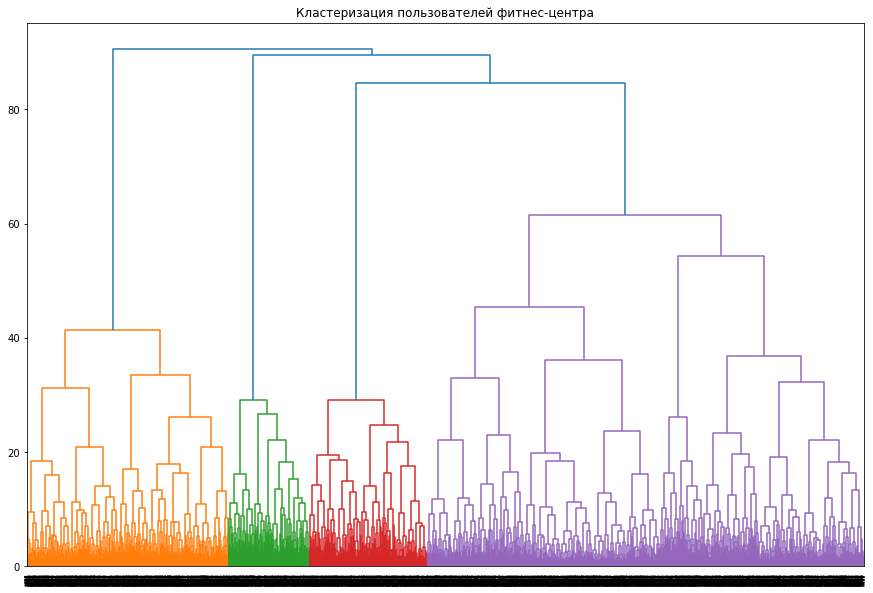

In [46]:
# Сохраним матрицу расстояний
links = linkage(x_st, method = 'ward')

# Построим дендрограмму
plt.figure(figsize=(15, 10))
plt.title('Кластеризация пользователей фитнес-центра')
dendrogram(links, orientation='top')
plt.show()

По дендрограмме можно предположить наличие четырёх кластеров в данных.

### Обучение модели кластеризации и прогноз кластеров клиентов <a id='step_4.3'></a>

Было принято решение для прогноза кластеров клиентов использовать пять кластеров. Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов.

In [47]:
# Зададим модель k_means с числом кластеров 5
km = KMeans(n_clusters = 5, random_state=0)

# Спрогнозируем кластеры для наблюдений
labels = km.fit_predict(x_st)

# Сохраним метки кластера в поле нашего датасета
gym_churn['cluster_km'] = labels

# Переименуем названия кластеров
gym_churn.loc[gym_churn['cluster_km']==0, 'cluster_km'] = 'cluster_1'
gym_churn.loc[gym_churn['cluster_km']==1, 'cluster_km'] = 'cluster_2'
gym_churn.loc[gym_churn['cluster_km']==2, 'cluster_km'] = 'cluster_3'
gym_churn.loc[gym_churn['cluster_km']==3, 'cluster_km'] = 'cluster_4'
gym_churn.loc[gym_churn['cluster_km']==4, 'cluster_km'] = 'cluster_5'

# Выведем средние значения признаков для кластеров
gym_churn.groupby('cluster_km').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_current_month,churn
cluster_km,,,,,,,,,,,,
cluster_1,0.490654,1.000000,0.217757,0.070093,1.0,2.047664,0.289720,27.673832,117.271746,1.935514,1.182898,0.558879
cluster_2,0.495943,0.995943,0.891481,1.000000,1.0,6.911765,0.523327,29.601420,153.355426,4.281947,1.919083,0.119675
cluster_3,0.523316,0.862694,0.471503,0.305699,0.0,4.777202,0.427461,29.297927,144.208179,3.940415,1.723967,0.266839
cluster_4,0.500000,0.000000,0.489247,0.078853,1.0,2.994624,0.232975,28.679211,137.125763,2.974910,1.597146,0.403226
cluster_5,0.546000,0.996000,0.380000,0.011000,1.0,6.204000,0.528000,30.627000,178.905160,5.425000,2.353631,0.017000


При взгляде на таблицу чётко отделяемые группы выделить можно по ряду признаков. Однако, для более наглядного разделения требуется построить распределение для каждого признака по кластерам.

### Анализ распределения признаков для кластеров <a id='step_4.4'></a>

Для анализа распределения признаков в кластерах построим *столбчатые диаграммы для логических и дискретных переменных* (пол, близость к фитнес-центру, принадлежность к компании-партнёру, первое посещение по акции "Приведи друга", наличие контакта, длительность абонемента, посещение групповых занятий, отток) и *боксплоты для непрерывных переменных* (возраст, время с момента первого обращения, показатели средней частоты посещений в неделю за месяц, выручка от других услуг).

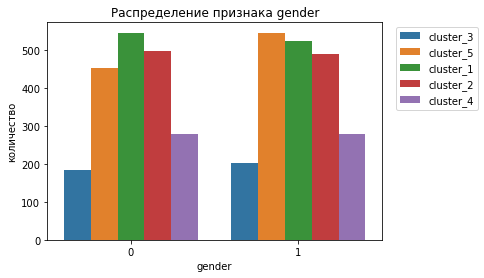

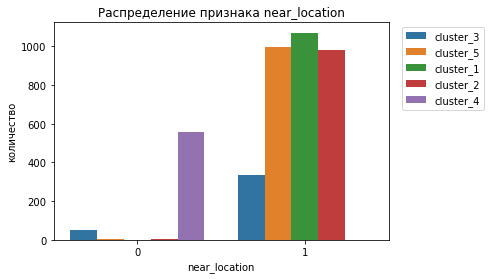

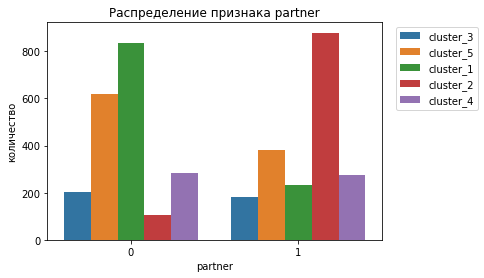

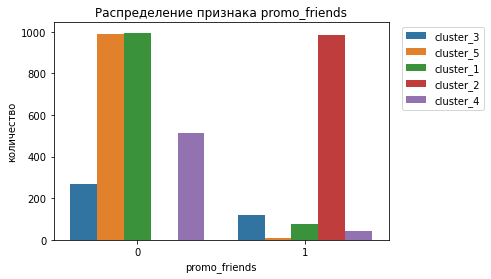

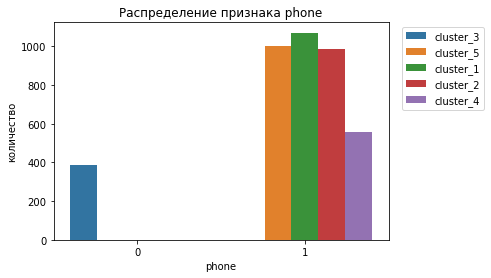

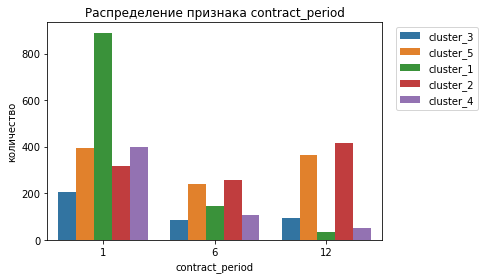

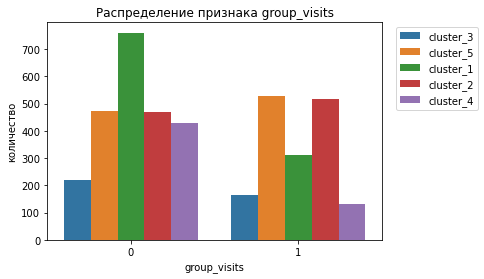

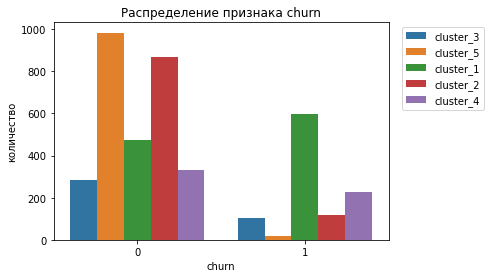

In [48]:
# Построим график для логических и дискретных величин
log_discr_values = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'contract_period', 'group_visits', 'churn']
fig, ax = plt.subplots()
for column in log_discr_values:
    plt.title("Распределение признака "+column)
    sns.countplot(data=gym_churn, x=column, hue='cluster_km')
    plt.xlabel(column)
    plt.ylabel("количество")
    plt.legend(bbox_to_anchor=(1.3, 1))
    plt.show()

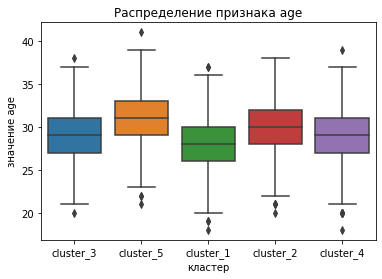

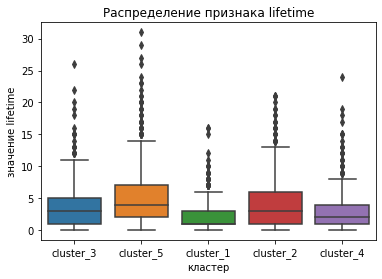

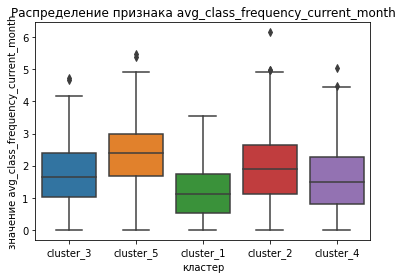

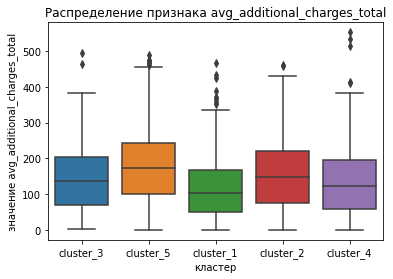

In [49]:
# Построим график для непрерывных величин
cont_values = ['age', 'lifetime', 'avg_class_frequency_current_month', 'avg_additional_charges_total']
fig, ax = plt.subplots()
for column in cont_values:
    plt.title("Распределение признака "+column)
    sns.boxplot(x='cluster_km', y=column, data=gym_churn)
    plt.xlabel('кластер')
    plt.ylabel('значение '+column)
    plt.show()

*Кластер 1* характеризуется:
- приблизительно равным распределением между мужчинами и женщинами;
- клиентами, которые находятся поблизости от фитнес-центра;
- клиентами, большинство из которых (около 80%) пришли не от компаний-партнёров;
- клиентами, которые пришли не по промо-акции от друзей;
- наличием контактных данных;
- абонементом на 1, 6 и 12 месяцев со значительным преобладанием абонементов на 1 месяц;
- клиентами, около 30% которых посещает групповые занятия;
- средним возрастом около 27,5 лет;
- низким уровнем дополнительных оплат;
- коротким сроком от начала пользования услугами;
- посещением около 1 раза в неделю.

*Кластер 2* характеризуется:
- приблизительно равным распределением между мужчинами и женщинами;
- клиентами, которые находятся поблизости от фитнес-центра;
- клиентами, большинство из которых (около 90%) пришло от компаний-партнёров;
- клиентами, большинство из которых (около 70%) пришло не по промо-акции от друзей;
- наличием контактных данных;
- абонементом на 1, 6 и 12 месяцев с примерно равным распределением и небольшим преобладанием 12 месяцев;
- клиентами, около половины которых посещает групповые занятия;
- средним возрастом около 29,5 лет;
- высоким уровнем дополнительных оплат;
- средним сроком от начала пользования услугами;
- посещением около 2 раз в неделю.

*Кластер 3* характеризуется:
- приблизительно равным распределением между мужчинами и женщинами;
- клиентами, большинство из которых находится вблизи от фитнес-центра;
- примерно равным числом посетителей от компаний-партнёров и обычных посетителей;
- клиентами, большинство из которых (около 70%) пришло не по промо-акции от друзей;
- отсутствием контактных данных;
- абонементом на 1, 6 и 12 месяцев с примерно равным распределением и небольшим преобладанием 1 месяца;
- клиентами, около 40% которых посещает групповые занятия;
- средним возрастом в 29-29,5 лет;
- средним уровнем дополнительных оплат;
- средним сроком от начала пользования услугами;
- посещением около 1,5-2 раз в неделю.

*Кластер 4* характеризуется:
- приблизительно равным распределением между мужчинами и женщинами;
- клиентами, живущими или работающими вдали от фитнес-центра;
- примерно равным числом посетителей от компаний-партнёров и обычных посетителей;
- клиентами, большинство из которых (около 75%) пришло не по промо-акции от друзей;
- наличием контактных данных;
- абонементом на 1, 6 и 12 месяцев с преобладанием 1 месяца;
- клиентами, около 25% которых посещает групповые занятия;
- средним возрастом около 28,5 лет;
- средним уровнем дополнительных оплат;
- небольшим сроком от начала пользования услугами;
- посещением около 1,5 раз в неделю.

*Кластер 5* характеризуется:
- чуть большим числом людей одного пола, по сравнению с другим;
- клиентами, которые находятся вблизи от фитнес-центра;
- клиентами, большинство из которых (около 65%) пришли не от компаний-партнёров;
- клиентами, которые пришли не по промо-акции от друзей;
- наличием контактных данных;
- абонементом на 1, 6 и 12 месяцев с примерно равным распределением и чуть меньшим количеством 6 месяцев;
- клиентами, около половины которых посещает групповые занятия;
- средним возрастом около 30,5 лет;
- очень высоким уровнем дополнительных оплат;
- длительным сроком от начала пользования услугами;
- посещением около 2-2,5 раз в неделю.

### Расчёт и анализ долей оттока для кластеров <a id='step_4.5'></a>

In [50]:
# Для каждого полученного кластера посчитаем долю оттока
(gym_churn
     .groupby('cluster_km')['churn']
     .mean()
     .reset_index()
     .sort_values(by='churn', ascending=False)
     .reset_index(drop=True))

,cluster_km,churn
0,cluster_1,0.558879
1,cluster_4,0.403226
2,cluster_3,0.266839
3,cluster_2,0.119675
4,cluster_5,0.017000


Первый кластер больше всего склонен к оттоку: доля составляет около 55-56%. Четвёртый кластер характеризуется долей оттока в 40%, а третий - около 27%.  Второй и пятый кластеры (доля оттока 12% и 2%, соответственно) являются самыми надёжными.

### Вывод <a id='step_4.6'></a>

После стандартизации данных была построена матрица расстояний и дендрограмма. По дендрограмме было высказано предположение о наличии четырёх кластеров в данных. Однако, было принято решение для прогноза кластеров клиентов использовать пять кластеров в модели K-Means. 

Анализ средних значений и распределений признаков для кластеров показал, что выделенные нами кластеры имеют следующие характеристики.

*Кластер 1* характеризуется:
- приблизительно равным распределением между мужчинами и женщинами;
- клиентами, которые находятся поблизости от фитнес-центра;
- клиентами, большинство из которых (около 80%) пришли не от компаний-партнёров;
- клиентами, которые пришли не по промо-акции от друзей;
- наличием контактных данных;
- абонементом на 1, 6 и 12 месяцев со значительным преобладанием абонементов на 1 месяц;
- клиентами, около 30% которых посещает групповые занятия;
- средним возрастом около 27,5 лет;
- низким уровнем дополнительных оплат;
- коротким сроком от начала пользования услугами;
- посещением около 1 раза в неделю.

*Кластер 2* характеризуется:
- приблизительно равным распределением между мужчинами и женщинами;
- клиентами, которые находятся поблизости от фитнес-центра;
- клиентами, большинство из которых (около 90%) пришло от компаний-партнёров;
- клиентами, большинство из которых (около 70%) пришло не по промо-акции от друзей;
- наличием контактных данных;
- абонементом на 1, 6 и 12 месяцев с примерно равным распределением и небольшим преобладанием 12 месяцев;
- клиентами, около половины которых посещает групповые занятия;
- средним возрастом около 29,5 лет;
- высоким уровнем дополнительных оплат;
- средним сроком от начала пользования услугами;
- посещением около 2 раз в неделю.

*Кластер 3* характеризуется:
- приблизительно равным распределением между мужчинами и женщинами;
- клиентами, большинство из которых находится вблизи от фитнес-центра;
- примерно равным числом посетителей от компаний-партнёров и обычных посетителей;
- клиентами, большинство из которых (около 70%) пришло не по промо-акции от друзей;
- отсутствием контактных данных;
- абонементом на 1, 6 и 12 месяцев с примерно равным распределением и небольшим преобладанием 1 месяца;
- клиентами, около 40% которых посещает групповые занятия;
- средним возрастом в 29-29,5 лет;
- средним уровнем дополнительных оплат;
- средним сроком от начала пользования услугами;
- посещением около 1,5-2 раз в неделю.

*Кластер 4* характеризуется:
- приблизительно равным распределением между мужчинами и женщинами;
- клиентами, живущими или работающими вдали от фитнес-центра;
- примерно равным числом посетителей от компаний-партнёров и обычных посетителей;
- клиентами, большинство из которых (около 75%) пришло не по промо-акции от друзей;
- наличием контактных данных;
- абонементом на 1, 6 и 12 месяцев с преобладанием 1 месяца;
- клиентами, около 25% которых посещает групповые занятия;
- средним возрастом около 28,5 лет;
- средним уровнем дополнительных оплат;
- небольшим сроком от начала пользования услугами;
- посещением около 1,5 раз в неделю.

*Кластер 5* характеризуется:
- чуть большим числом людей одного пола, по сравнению с другим;
- клиентами, которые находятся вблизи от фитнес-центра;
- клиентами, большинство из которых (около 65%) пришли не от компаний-партнёров;
- клиентами, которые пришли не по промо-акции от друзей;
- наличием контактных данных;
- абонементом на 1, 6 и 12 месяцев с примерно равным распределением и чуть меньшим количеством 6 месяцев;
- клиентами, около половины которых посещает групповые занятия;
- средним возрастом около 30,5 лет;
- очень высоким уровнем дополнительных оплат;
- длительным сроком от начала пользования услугами;
- посещением около 2-2,5 раз в неделю.

Первый кластер больше всего склонен к оттоку: доля составляет около 55-56%. Четвёртый кластер характеризуется долей оттока в 40%, а третий - около 27%. Второй и пятый кластеры (доля оттока 12% и 2%, соответственно) являются самыми надёжными.

## Общий вывод <a id='step_5'></a>

Было проведено исследование **данных о клиентах фитнес-центра «Культурист-датасаентист»**. Эти данные содержат в себе информацию о 4 000 клиентов и 14 показателях, один из которых (отток клиентов выбран в модели в качестве результирующего). Анализируемыми показателями, которые влияют на отток выбраны следующие характеристики клиентов: пол, близость к фитнес-центру, принадлежность к компании-партнёру фитнес-центра, факт первоначальной записи в рамках промо-акции «приведи друга», наличие контактного телефона, возраст, время с момента первого обращения в фитнес-центр, длительность текущего действующего абонемента, срок до окончания действующего абонемента, факт посещения групповых занятий, средняя частоа посещений в неделю за все время с начала действия абонемента и за предыдущий месяц, суммарная выручка от других услуг фитнес-центра.

Анализ данных позволил сделать **следующие выводы**.
1. Средняя по оттоку клиентов близка к 0,3, а медиана равна 0.

Соответственно, **около трети клиентов фитнес-центра уходит в отток**.

2. Средняя по полу клинтов близка к 0,5, а медиана равна 1.

Соответственно, **услугами фитнес-центра пользуются в равной степени мужчины и женщины**.

3. Средняя по близости к фитнес-центру близка к 0,85, а первый квартиль равен 1. Распределения по признаку не сильно отличаются. Среднее значение для лояльных клиентов чуть выше, чем для людей, уходящих в отток.

Таким образом, **фитнес-центр посещает больше клиентов, которые живут поблизости. При этом немного лояльнее к фитнес-центру те, кто живёт поблизости**, чем те, кто живёт в отдалении.

4. Средняя по принадлежности к компании-партнёру близка к 0,5. Распределения для ушедших в отток и оставшихся клиентов ведут себя по-разному.

Так, **в фитнес-центре в равной степени представлены клиенты, являющиеся сотрудниками компаний-партнёров, и люди, не имеющие к ним отношение. Но ушедшие в отток клиенты в большей степени не являются сотрудниками компаний-партнёров**.

5. Средняя по пришедшим по промо-акции "Приведи друга" равна 0,3, медиана равна 0. Распределения для ушедших в отток и лояльных клиентов близки, но средние значения немного отличаются (для второй группы значение выше).

Соответственно, **большинство клиентов фитнес-центра не пришло по промо-акции "Приведи друга", но среди лояльных клиентов воспользовавшихся акцией больше, чем среди уходящих в отток**.

6. Средняя по наличию контактного телефона близка к 0,9, а четвёртый квартиль равен 1. Распределения по лояльным и нелояльным клиентам имеют схожий вид.

Тамим образом, **практически все клиенты фитнес-центра оставляют контакты для связи - вне зависимости от того, останутся они в фитнес-центре, или уйдут в отток**.

7. Минимальное значение возраста равно 18, максимальное - 41, среднее - 29. Среднее значение близко к медиане, стандартное отклонение очень низкое, распределение для лояльных и нелояльных клиентов нормальное. Распределение для лояльных клиентов немного смещено вправо со средней в 30, а для ушедших клиентов - влево со средней в 27.

Соответственно, **услугами фитнес-центра пользуются клиенты возрастом от 18 до 41 года (со средним возрастом около 29 лет). Причём в отток в дальнейшем уходят клиенты более молодого возраста (около 27 лет)**.

8. Минимальное значение времени с первого обращения равно 0, максимальное - 31, среднее - 3, медиана близка к 4 месяцам. Распределение времени с момента первого обращения для обоих групп (лояльных и нелояльных) похоже на распределение Пуассона. Но для ушедших в отток клиентов оно сильно смещено влево (со средним в 1 месяц), практически не имея значения в более высоких значениях, а для лояльных клиентов принимает более высокие значения (со средним в 5 месяцев).

Таким образом, **в фитнес центре есть "новенькие" клиенты** (которые несколько месяцев пользуются услугами центра) **и "опытные" клиенты** (которые достаточно давно начали посещать фитнес-центр). **При этом клиенты, проявляющие уже в первые несколько месяцев лояльность к фитнес-центру, скорее всего, не уйдут в отток в последующие месяцы**.

9. Показатель длительности абонемента может принимать значения 1, 6 и 12 месяцев. Среднее значение равно 4-5 месяцев. При этом есть перекос в данных: медиана равна 1 месяцу. Среднее значение для лояльных пользователей - 5-6 месяцев, для уходящих в отток - 1-2 месяца. Показатель времени до окончания абонемента принимает значения от 1 до 12 месяцев. Среднее значение равно 4 месяца, При этом есть перекос в данных: медиана равна 1 месяцу. Различия в распределении групп (лояльных и нелояльных клиентов) по сроку до окончания действующего абонемента такие же, как и в распределениях по длительности абонемента.

Соответственно, **клиенты предпочитают покупать абонемент на короткий срок, но купившие более длительный абонемент с большей неохотой уйдут в отток, чем те, у кого он действует короткий срок**. 

10. Средняя по посещаемости групповых занятий близка к 0,4, а медиана равна 0. Распределения по лояльным и уходящим в отток клиентам различаются.

Так, **среди клиентов фитнес-центра больше тех, кто не интересуется групповыми занятиями (около 60%). При этом уходящие в отток клиенты практически не заинтересованы в таких занятиях**.

11. Средняя частота посещений за всё время с начала действия абонемента и за предыдущий месяц колеблются в промежутке от 0 до 6 раз в неделю. Среднее значение и медиана практически равны, стандартное отклонение невысоко. Распределение для лояльных и нелояльных групп является нормальным. Для лояльной группы оно немного смещено влево (среднее 1-2), а для группы уходящих в отток имеется сильное смещение влево (среднее около 2).

Соответственно, **в фитнес-центре есть люди, которые купили абонемент, но ни разу не посетили центр, а есть и очень "приверженные" клиенты** (посещение 6 раз в неделю). **При этом, в среднем, все клиенты посещают центр около 1-2 раз в неделю. Однако, среди лояльных клиентов много тех, кто часто посещает фитнес-центр**.

12. Выручка с клиента от прочих услуг фитнес-центра сильно колеблется от 0,15 до 552,6 ден.ед. Среднее значение равно 147 ден.ед, а медиана - 136 ден.ед. Между группами (лояльные и нелояльные клиенты) различие в среднем значении составляет 43 ден.ед. (для лояльных значение выше). Распределение средней выручки от других услуг фитнес-центра для обоих датасетов смещено влево с большим смещением для ушедших людей. 

Таким образом, **затраты на прочие услуги фитнес-центра очень сильно варьируются для клиентов. При этом уходящие в отток клиенты склонны экономить, а среди лояльных клиентов встречаются те, кто готов заплатить очень высокую цену**.

13. Основные метрики полученных моделей, построенных алгоритмом логистической регрессии и алгоритмом случайного леса, следующие. Для модели логистической регрессии: Accuracy = 0,92; Precision = 0,85; Recall = 0,84; F1 = 0,84; ROC_AUC = 0,97. Для модели случайного леса: Accuracy = 0,91; Precision = 0,85; Recall = 0,77; F1 = 0,81; ROC_AUC = 0,96.

Таким образом, **и модель логистической регрессии, и модель случайного леса достаточно хорошо способны делать прогноз. Однако, модель логистической регрессии подходит больше** по всем показателям: доле правильных ответов (accuracy), точности (precision), полноте (recall), агрерующей метрике F1 и наиболее точной метрике оценки качества классификатора ROC_AUC.

14. По дендрограмме было высказано предположение о наличии четырёх кластеров в данных. Однако, было принято решение для прогноза кластеров клиентов использовать пять кластеров в модели K-Means. 

Анализ средних значений и распределений признаков для кластеров показал, что **выделенные кластеры имеют следующие отличительные характеристики**.

**Кластер 1** - это клиенты, находящиеся поблизости от фитнес-центра, большинство из которых пришло не от компаний-партнёров и не по промо-акции от друзей, с абонементом на 1, 6 и 12 месяцев (со значительным преобладанием первых), для трети из которых групповые занятия важны, с низким уровнем дополнительных оплат, являющиеся нашими "новыми" клиентами, посещающие фитнес-центр около 1 раза в неделю. Для них **доля оттока близка к 56% -  это наиболее склонный к оттоку кластер**.

**Кластер 2** - это клиенты,находящиеся поблизости от фитнес-центра, большинство из которых пришло от компании-партнёров и не по промо-акции от друзей, с абонементом на 1, 6 и 12 месяцев в примерно равных пропорциях с небольшим преобладанием 12 месяцев, около половины которых посещает групповые занятия, с высоким уровнем дополнительных оплат, некоторое время являющиеся нашими клиентами, посещающие фитнес-центр около 2 раз в неделю. Для них **доля оттока близка к 12% - это один из самых надёжных кластеров**.

**Кластер 3** - это клиенты, большинство из которых находится вблизи от фитнес-центра, пришедшие примерно в равных пропорциях от компаний-партнёров и не от них, большинство из них пришло не по промо-акции от друзей, без контактных данных, с абонементами на 1, 6 и 12 месяцев (с примерно равным распределением и небольшим преобладанием абонементов на 1 месяц), для большинства из которых (60%) групповые занятия не важны, со средним уровнем дополнительных оплат, некоторое время являющиеся нашими клиентами, посещающие фитнес-центр около 1,5-2 раз в неделю. Для них **доля оттока близка к 27%**.

**Кластер 4** - это клиенты, живущие или работающие вдали от фитнес-центра, пришедшие примерно в равных пропорциях от компаний-партнёров и не от них, большинство из них пришло не по промо-акции от друзей, с абонементами на 1, 6 и 12 месяцев (с преобладанием абонементов на 1 месяц), для большинства из которых групповые занятия не важны, со средним уровнем дополнительных оплат, небольшим сроком от начала пользования услугами, посещающие фитнес-центр около 1,5 раз в неделю. Для них **доля оттока близка к 40% - это в очень большой степени склонный к оттоку кластер**.

**Кластер 5** - это клиенты с небольшим преобладанием людей одного пола, по сравнению с другим, которые живут или работают возле фитнес-центра, пришедшие в большинстве своём не от компаний-партнёров и не по промо-акции от друзей, с абонементами на 1, 6 и 12 месяцев (с примерно равным распределением 1 и 12 месяцев, и чуть меньшим количеством 6 месяцев), около половины из которых посещает групповые занятия, с очень высоким уровнем дополнительных оплат, являющиеся нашими постоянными "давними" клиентами, посещающие фитнес-центр около 2-2,5 раз в неделю. Для них **доля оттока близка к 2% - это самый надёжный кластер**.

## Рекомендации <a id='step_6'></a>

На основе представленных выводов, предложены **следующие рекомендации** для стратегии взаимодействия с пользователями сети фитнес-центров «Культурист-датасаентист» и их удержания.

1) Рекомендуется привлечение в фитнес-центр **клиентов из близлежащих спальных районах**.

2) Рекомендуется **отменить проведение акции "Приведи друга" и акций для сотрудников компаний-партнёров** - поскольку они не способствует "удержанию" клиентов, а высвободившиеся деньги направить на другие мероприятия (например, раздача листовок в близлежащих спальных районах - п.1).

3) Возможно внедрение и реклама **абонементов более длительного срока (9 и 12 месяцев)** - поскольку чем дольше времени до окончания абонемента, тем лояльнее клиенты. 

4) Поскольку категория с длительными абонементами имеет склонность пользоваться доп услугами, для них возможно **введение специальных скидок и акций по доп услугам**.

5) Рекомендуется установить **более выгодные цены на длительные абонементы**. Например, цена на абонемент на 3 месяца (нужно внедрить абонементы на 3 месяца) ненамного дороже, чем на абонемент на 1 месяц (чтобы покупатель стремился покупать 3 месяца) - это снизит риски оттока клиентов в первые месяцы.

6) Возможно ввести **более выгодное продление абонемента** для клиентов, покупающих абонемент **сроком от 3 месяцев**. Например, по окончании абонемента покупка нового тем же сроком - скидка 25%. Подобные скидки окупятся доп услугами, которыми пользуются лояльные клиенты и отменой неэффективных акций.

7) Рекомендуется проводить **мониторинг средней частоты посещений фитнес-центра в неделю** по клиентам. При обнаружении снижения показателя предлагать клиентам "бонусы" (бесплатная разовая доп услуга, скидки на продление абонемента, одно бесплатное групповое занятие по новому для него направлению и т.п.).